## REQUIRED PACKAGES

In [1]:
# Model packages
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Activation, LSTM, TimeDistributed, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as k
from keras.models import load_model

# Dataset management packages
from spivutils.synthetic_datasets.spid import load_data
from spivutils.batch_generators.keras_generator import batch_data
from spivutils.common_tools.operations import normalization, vectoraddition, thresholding, imagecropping

# General purpose packages
import numpy as np

# 
import matplotlib.pyplot as plt

# 
import pandas as pd
import json

2023-11-13 18:08:23.843940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 18:08:24.565783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## DATA MANAGEMENT

In [2]:
batch_size = 5

# Data importing
_, _, (test_x, test_y) = load_data()

test_batch = batch_data(test_x, test_y, batch_size)


 Checking files ...

 train_x.npy  Found!

 train_y.npy  Found!

 valid_x.npy  Found!

 valid_y.npy  Found!

 test_x.npy  Found!

 test_y.npy  Found!

 Importing data ...

 Data loading successful!


## PRE PROCESSING

In [3]:
def standardization(input_data):

    output_data = np.zeros(input_data.shape)

    #min = np.min(input_data)
    #max = np.max(input_data)

    max = 8.75
    min = 0

    output_data[:, :, :] = (input_data[:, :, :] - min)/(max - min)

    #for i in range(2):

    #    output_data[:, i, :, :] = (input_data[:, i, :, :] - min)/(max - min)

    return output_data

In [4]:
# Crops a square region with size equals to small image dimension at the center of the image
test_batch.add_x_preprocessing_operation(imagecropping)

# Crops a square region with size equals to small image dimension at the center of the image
test_batch.add_y_preprocessing_operation(imagecropping)

#
test_batch.add_y_preprocessing_operation(vectoraddition)

# Apply normalization to the input data
test_batch.add_x_preprocessing_operation(normalization)

# Apply normalization to the output data
test_batch.add_y_preprocessing_operation(standardization)

## MODEL LOADING

In [5]:
loaded_model = load_model('/home/michel/projetos/PIVML/model_1_23_00.keras')



2023-11-13 18:08:34.685243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 18:08:34.706592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 18:08:34.706841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 18:08:34.710052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 18:08:34.710363: I tensorflow/compile

In [6]:
with open('/home/michel/projetos/PIVML/model_1_23_00_training_history.json', 'r') as json_file:
    training_history = json.load(json_file)

## MODEL EVALUATION


Training evaluation

In [7]:
def plot_loss(history):
    loss = history['loss']
    valloss = history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r', label = 'treinamento')
    plt.plot(epochs, valloss, 'b', label = 'validação')
    plt.title('Erro quadrático médio')
    plt.xlabel('Epocas')
    plt.ylabel('Erro')
    plt.legend()


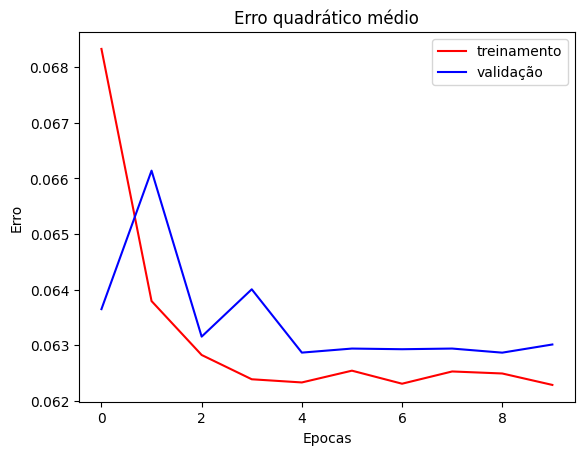

In [8]:
plot_loss(training_history)

In [9]:
results = loaded_model.evaluate(test_batch)

2023-11-13 18:09:01.712378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


648/648 [==============================] - 293s 448ms/step - loss: 0.0618


## FLOW EVALUATION

Plot function

In [ ]:
def plot_flow(u, v, V, title, step = 50):

    width, height = u.shape

    x, y = np.meshgrid(np.arange(0, width), np.arange(0, height), indexing = 'xy')

    # Subsamples the data to reduce the density of arrows
    x_subsampled = x[::step, ::step]
    y_subsampled = y[::step, ::step]
    u_subsampled = u[::step, ::step]
    v_subsampled = v[::step, ::step]

    # Heat map plot
    plt.imshow(V, cmap = 'jet', extent = (0, width, 0, height), origin = 'lower')
    plt.colorbar(label = 'Velocity Magnitude')

    # Vector field plot
    plt.quiver(x_subsampled, y_subsampled, u_subsampled, v_subsampled)

    plt.title(title)
    plt.xlabel('x coordinate [pixels]')
    plt.ylabel('y coordinate [pixels]')
    plt.show()

Ground Truth Flow

In [ ]:
true_label = test_batch[2][1]

# Determines the true velocity components
true_u = true_label[0][0]
true_v = true_label[0][1]

# Determines the true velocity magnitude
true_V = np.sqrt(true_u**2 + true_v**2)

# Plot the ground thuth flow
plot_flow(true_u, true_v, true_V, 'True Velocity Field')

Predicted Flow

In [ ]:
input_to_predict = test_batch[0][0]

predicted_label = loaded_model.predict(input_to_predict)

predicted_u = predicted_label[0]
predicted_v = predicted_label[1]
predicted_V = np.sqrt(predicted_u**2 + predicted_v**2)

# Plot the predicted flow
plot_flow(predicted_u, predicted_v, predicted_V, 'Predicted Velocity Field')

# TESTE

In [10]:
def plot_flow(V, title, step = 50):

    # Heat map plot
    plt.imshow(V, cmap = 'jet')
    plt.colorbar(label = 'Magnitude da Velocidade')
    plt.title(title)
    plt.xlabel('coordenada x [pixeis]')
    plt.ylabel('coordenada y [pixeis]')
    plt.show()

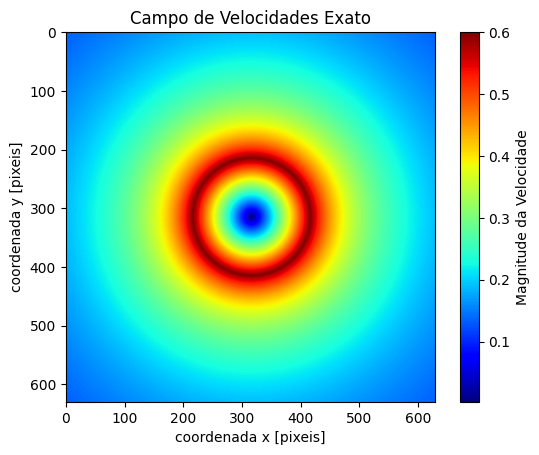

1/1 [==============================] - 0s 31ms/step


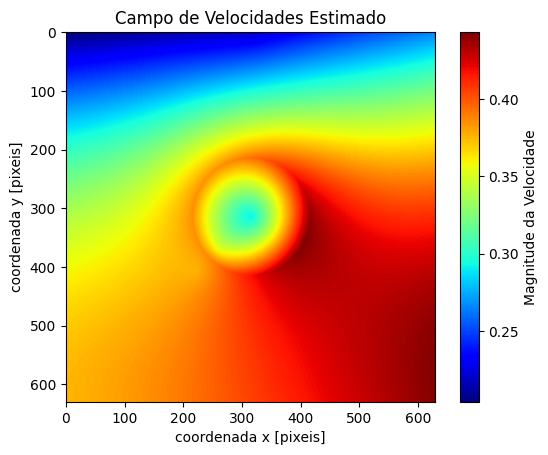

In [13]:
sample = 100

batch = int(np.floor(sample/batch_size))
image = abs(batch*batch_size - sample)

true_label = test_batch[batch][1][image]
plot_flow(true_label, 'Campo de Velocidades Exato')

input_to_predict = test_batch[batch][0]
predicted_label = loaded_model.predict(input_to_predict)[image]
plot_flow(predicted_label, 'Campo de Velocidades Estimado')

In [ ]:
true_label = test_batch[0][1][0]
plot_flow(true_label, 'Campo de Velocidades Exato')

In [ ]:
plot_flow(0,0, test_batch[0][1][0], 'Campo de Velocidades Exato')